Установка библиотек

In [3]:
pip install numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install torch torchvision

  Using cached torch-2.6.0-cp39-cp39-win_amd64.whl.metadata (28 kB)
Using cached torch-2.6.0-cp39-cp39-win_amd64.whl (204.1 MB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Проверяем какое устройство будет использоваться

In [2]:
print(torch.cuda.is_available())  # Должно вернуть True, если GPU доступен
print(torch.cuda.get_device_name(0))  # Название вашей видеокарты

True
NVIDIA GeForce RTX 4070 Ti SUPER


In [3]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Выполняем задание

100%|██████████| 9.91M/9.91M [00:03<00:00, 3.29MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 247kB/s]
100%|██████████| 1.65M/1.65M [00:04<00:00, 330kB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298528
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.412688
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.378260
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.159089
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.250205
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.252559
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.155127
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.169140
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.065780
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.124497

Test set: Average loss: 0.0017, Accuracy: 9648/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.075863
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.063635
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.009135
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.093781
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.183048
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.103721
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.065241
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.095565
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.085321
T

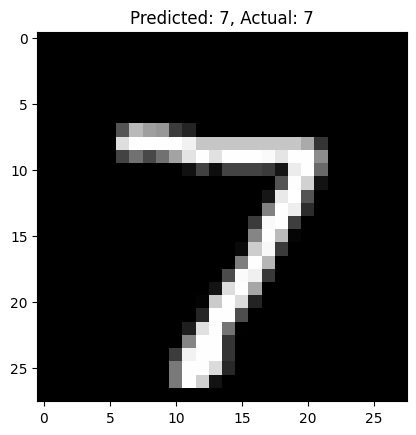

In [4]:
# 1. Создание собственного датасета
class MNISTDataset(Dataset):
    def __init__(self, train=True):
        self.mnist_data = datasets.MNIST(
            root='./data',
            train=train,
            download=True,
            transform=transforms.ToTensor()  # Преобразует изображения в тензоры и нормализует их в [0, 1]
        )

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, idx):
        image, label = self.mnist_data[idx]
        image = image.view(-1)  # Преобразуем изображение в одномерный тензор (28x28 -> 784)
        return image, label

# 2. Создание DataLoader
train_dataset = MNISTDataset(train=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = MNISTDataset(train=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# 3. Создание модели MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # Входной слой: 784 -> 512
        self.fc2 = nn.Linear(512, 256)      # Скрытый слой: 512 -> 256
        self.fc3 = nn.Linear(256, 10)        # Выходной слой: 256 -> 10 (10 классов)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Функция активации ReLU
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Не применяем Softmax, так как CrossEntropyLoss делает это автоматически
        return x

# Инициализация модели, функции потерь и оптимизатора
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Функция для обучения
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# 5. Функция для тестирования
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # Получаем индекс максимального значения
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# 6. Обучение модели
for epoch in range(1, 11):  # 10 эпох
    train(epoch)
    test()

# 7. Пример предсказания
model.eval()
with torch.no_grad():
    data, target = test_dataset[0]
    data = data.to(device)
    output = model(data)
    pred = output.argmax(dim=0, keepdim=True)  # Получаем предсказанный класс
    print(f'Predicted: {pred.item()}, Actual: {target}')

    # Визуализация изображения
    plt.imshow(data.cpu().view(28, 28), cmap='gray')
    plt.title(f'Predicted: {pred.item()}, Actual: {target}')
    plt.show()